<a href="https://colab.research.google.com/github/ekity1002/DL4US_homeworks/blob/master/lesson5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson5 画像からキャプションを生成してみよう

## Homework

本Lessonで学んだことを生かして，画像からのキャプション生成を実装してみましょう。

ネットワークの形などは特に制限を設けませんし、今回のLessonで扱った内容以外の工夫も組み込んでもらって構いません。

精度上位者はリーダーボードに掲載させていただきます。（精度の評価はBLEUスコアによって行います。）

## 目標値

BLUE: 0.05

## ルール

- Lesson中で登場したbeam_searchを使って以下のサンプルも参考にしながらキャプションを生成しcsvファイルに出力して下さい。
- **BLEUスコア(2-gramまで)**で評価します。

## 評価について

- テストデータ(x_test)に対する予測ラベルをcsvファイルで提出してください。
- ファイル名はsubmission.csvとしてください。
- 予測ラベルのy_testに対する精度 (F値)で評価します。
- 毎日24時にテストデータの一部に対する精度でLeader Boardを更新します。
- 最終的な評価はテストデータ全体に対する精度でおこないます。

## サンプルコード

**次のセルで指定されているx_train, y_trainのみを使って学習させてください。**

In [0]:
! pip3 install tqdm

You are using pip version 8.1.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
import sys
import csv
import copy
from tqdm import tqdm
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Flatten, Lambda, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional
from tensorflow.keras.layers import Reshape, Activation, concatenate, dot
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.model_selection import KFold

SEED=9999

def load_data():
    # 学習データ
    x_train = np.load('/root/userspace/public/lesson5/data/x_train.npy')
    y_train = np.load('/root/userspace/public/lesson5/data/y_train.npy')
    tokenizer = np.load('/root/userspace/public/lesson5/data/tokenizer.npy').item()
    
    # テストデータ
    x_test = np.load('/root/userspace/public/lesson5/data/x_test.npy')

    return (x_train, y_train, tokenizer, x_test)

x_train, y_train, tokenizer, x_test = load_data()

In [0]:
# 色々定義
detokenizer = dict(map(reversed, tokenizer.word_index.items()))
vocab_size = len(tokenizer.word_index) + 1
#print(vocab_size)
bos_eos = tokenizer.texts_to_sequences(["<s>", "</s>"])

emb_dim = 2048
hid_dim = 512
#RESHAPE_DIM = 512 #vgg
RESHAPE_DIM = 2048 #xception

y_train = pad_sequences(y_train, padding='post')
caption_len = len(y_train[0])
print(y_train.shape)

(27000, 12)


以下、サンプルコードになります。

In [0]:
# 学習済みモデル定義と特徴量の抽出
K.clear_session()

# 学習済みモデル
encoder_input = Input(shape=(224, 224, 3))
encoder_input_normalized = Lambda(lambda x: x / 255.)(encoder_input) # [0, 255) -> [0, 1)
#encoder = VGG16(weights='imagenet', include_top=False, input_tensor=encoder_input_normalized)# VGG
encoder = Xception(weights='imagenet', include_top=False, input_tensor=encoder_input_normalized)# Xception

# パラメータを固定
for layer in encoder.layers:
    layer.trainable = False

# CNNの出力
u = Flatten()(encoder.output)

vgg_model = Model(encoder_input, u)

# 学習済みモデルから特徴量を抽出
x_train_features = []
x_test_features = []

# 特徴量保存コード
# for x in tqdm(x_train):
#     x_features = vgg_model.predict(x[np.newaxis]).flatten()
#     x_train_features.append(x_features)

# x_train_features = np.stack(x_train_features, axis=0)
# np.save('/root/userspace/lesson5/data/x_train_xception_features', x_train_features)
# del x_train_features
# gc.collect()

# for x in tqdm(x_test):
#     x_features = vgg_model.predict(x[np.newaxis]).flatten()
#     x_test_features.append(x_features)

# x_test_features = np.stack(x_test_features, axis=0)
# # # 特徴量を保存
# np.save('/root/userspace/lesson5/data/x_test_xception_features', x_test_features)
# del x_test_features
#gc.collect()

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# 特徴量の読み込み
# x_train_features = np.load('/root/userspace/lesson5/data/x_train_features.npy') #vgg
# x_test_features = np.load('/root/userspace/lesson5/data/x_test_features.npy') #vgg
x_train_features = np.load('/root/userspace/lesson5/data/x_train_xception_features.npy')
x_test_features = np.load('/root/userspace/lesson5/data/x_test_xception_features.npy')

In [0]:
# Encoderの出力
print("x_train_features: ", x_train_features.shape)
# VGG_INPUT = 25088
# u = Input(shape=(VGG_INPUT,))
XCEPTION_INPUT = 100352
#u = Input(shape=(XCEPTION_INPUT,))
imp_u = Input(shape=(XCEPTION_INPUT,))

# dropout 画像のチャネル方向に歪みをかける
# lossは下がるようだが BELUに効果があるかというと。。。謎。
u = Reshape((7*7 ,RESHAPE_DIM))(imp_u)
u_shape = K.shape(u)
u = Dropout(0.2, noise_shape=(u_shape[0], u_shape[1], 1))(u)
u = Flatten()(u)

# LSTMの初期状態
decoded_states = [Dense(hid_dim)(u), Dense(hid_dim)(u)] # h_0, c_0 に対応
print("decoded_states: ", Dense(hid_dim)(u))
# 層の定義
decoder_input = Input(shape=(caption_len,))
embedding = Embedding(vocab_size, emb_dim, mask_zero=True)
lstm = LSTM(hid_dim, activation='tanh', return_sequences=True, return_state=True)
dense = Dense(vocab_size, activation='softmax')

# 層の接続
decoder_embedded = embedding(decoder_input)
print("decoder_embedded: ", decoder_embedded.shape)
decoder_output, _, _ = lstm(decoder_embedded, initial_state=decoded_states) # 第2,3戻り値(最終ステップのh, c)は無視
print("decoder_output, :", decoder_output.shape)

x_train_features:  (27000, 100352)
@@@
(?, 49, 2048) Tensor("Shape:0", shape=(3,), dtype=int32)
@@@
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
decoded_states:  Tensor("dense_2/BiasAdd:0", shape=(?, 512), dtype=float32)
decoder_embedded:  (?, 12, 2048)
decoder_output, : (?, 12, 512)


In [0]:
# Attention
# 0. reshape: (7, 7, RESHAPE_DIM) -> (49, RESHAPE_DIM)
u_map = Reshape((7*7, RESHAPE_DIM))(u)

# 1. スコアの計算
dense_att = Dense(hid_dim)
print("decoder_output: ", decoder_output.shape)
print("dense_att: ", dense_att(u_map).shape)
score = dot([decoder_output, dense_att(u_map)], axes=-1)
print("score: ", score.shape)

# 2. 重みの計算
attention = Activation('softmax')(score)
print("attention: ", attention.shape)

# 3. 文脈ベクトルの計算
context = dot([attention, u_map], axes=(2,1))
print("umap: ", u_map.shape)
print("context: ", context.shape)

# 4. 出力ベクトルの計算
attention_dense = Dense(hid_dim, activation='tanh')
output_dense = Dense(vocab_size, activation='softmax')
concat = concatenate([context, decoder_output], axis=2)
print("concat: ", concat.shape)
attentional = attention_dense(concat)
print("attentional: ", attentional.shape)
y_pred = output_dense(attentional)

# モデル構築
#model = Model([u, decoder_input], decoder_pred)
#model = Model([u, decoder_input], y_pred)
model = Model([imp_u, decoder_input], y_pred)
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

decoder_output:  (?, 12, 512)
dense_att:  (?, 49, 512)
score:  (?, 12, 49)
attention:  (?, 12, 49)
umap:  (?, 49, 2048)
context:  (?, 12, 2048)
concat:  (?, 12, 2560)
attentional:  (?, 12, 512)


In [0]:
# モデル図出力
# from IPython.display import SVG
# from tensorflow.python.keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
# サンプリング用（生成用）のモデルを作成

# LSTMの初期状態を決めるネットワーク
encoder_model = Model(imp_u, decoded_states)

# 復号化器
decoder_states_inputs = [Input(shape=(hid_dim,)), Input(shape=(hid_dim,))] # decorder用lstmの初期状態指定用(h_t, c_t)

decoder_input = Input(shape=(1,))
decoder_embedded = embedding(decoder_input) # 学習済みEmbeddingレイヤーを利用
decoder_output, *decoder_states = lstm(decoder_embedded, initial_state=decoder_states_inputs) # 学習済みLSTMレイヤーを利用
#decoder_pred = dense(decoder_output) # 学習済みDenseレイヤーを利用
decoder_model = Model([decoder_input] + decoder_states_inputs, [decoder_output] + decoder_states)

# Attention
u_map_in, decoded_seq_in = Input(shape=(7*7, RESHAPE_DIM)), Input(shape=(1, hid_dim))
score = dot([decoded_seq_in, dense_att(u_map_in)], axes=-1)
print("gen score: ", score.shape)
attention = Activation('softmax')(score)
print("gen attention: ", attention.shape)
context = dot([attention, u_map_in], axes=(2,1))
print("context: ", context.shape)
concat = concatenate([context, decoded_seq_in], axis=2)
print("concat: ", concat.shape)
attentional = attention_dense(concat)
print("attentional: ", attentional.shape)
attention_outputs = output_dense(attentional)
print("att_outputs: ", attention_outputs.shape)

attention_model = Model([u_map_in, decoded_seq_in], [attention_outputs, attention])

gen score:  (?, 1, 49)
gen attention:  (?, 1, 49)
context:  (?, 1, 2048)
concat:  (?, 1, 2560)
attentional:  (?, 1, 512)
att_outputs:  (?, 1, 10915)


In [0]:
from collections import OrderedDict
sys.path.append('/root/userspace/lesson5/master/') # 検証用

# logの中身が0になるのを防ぐ
def np_log(x):
    return np.log(np.clip(x, 1e-10, x))

class Node:
    #Attentioon 可視化用クラス
    def __init__(self, data):
        self.data = data
        self.children = OrderedDict()
        self.best = False
        self.depth = 1

    def __str__(self):
        return str(self.data)

    def add_child(self, path):
        if len(path) == 2:
            self.children[path[-1]] = Node(path[-1])
        else:
            self.children[path[1]].add_child(path[1:])

    def set_coordinates(self, x, y, ax, i2w, tree_depth):
        self.x = x
        self.y = y
        if self.best == True:
            ax.text(x, y+0.2, i2w[self.data], ha='center', fontsize=100/tree_depth, fontweight='bold', color='blue')
        else:
            ax.text(x, y+0.2, i2w[self.data], ha='center', fontsize=100/tree_depth, fontweight='bold', color='black')
        if self.best == True:
            ax.scatter(x, y, s=200/tree_depth, c='cyan', edgecolor='blue', linewidth=1, zorder=2)
        else:
            ax.scatter(x, y, s=200/tree_depth, c='grey', edgecolor='black', zorder=1)
        if len(self.children) != 0:
            for child_str, child_node in self.children.items():
                x += 1
                if self.best == True and child_node.best == True:
                    ax = plot_curve(self.x, x, self.y, y, ax, c='blue', linewidth=2, zorder=2, alpha=0.6)
                else:
                    ax = plot_curve(self.x, x, self.y, y, ax, c='grey', linewidth=2, zorder=1, alpha=0.6)
                x, y, ax = self.children[child_str].set_coordinates(x, y, ax, i2w, tree_depth)
                x -= 1
            return x, y, ax
        else:
            y -= 0.8
            return x, y, ax

    def mark_best_path(self, path):
        if len(path) != 1:
            self.best = True
            self.children[path[1]].mark_best_path(path[1:])
        else:
            self.best = True

def plot_curve(x_begin, x_end, y_begin, y_end, ax, c, linewidth, zorder, alpha):
    xs = np.linspace(x_begin, x_end, 1000)
    if y_begin != y_end:
        ys = (np.cos(np.linspace(0, np.pi, 1000)) - 1) * (y_begin - y_end) / 2 + y_begin
    else:
        ys = np.ones(1000) * y_begin

    ax.plot(xs, ys, c=c, linewidth=linewidth, zorder=zorder, alpha=alpha)
    return ax

In [0]:
def beam_search(input_features, bos_eos, encoder_model,
                K=5, max_output_length = 15):
    # LSTMの初期状態を取得
    states = encoder_model.predict(input_features)
    
    u_map = input_features.reshape(-1, 7*7, RESHAPE_DIM)
    
    # 上位K個の候補を保存するlist. listの各要素は [候補のスコア (累積の対数尤度), 出力された系列, アテンションの重み, 前時刻での隠れ層・セルの状態] を保持する
    candidates = [[0, np.array(bos_eos[0]), np.empty((0, 7*7)), states]]
    
    # 可視化用のnode
    root = Node(bos_eos[0][0])
    
    # max_output_lengthに到達するまでdecoding
    t = 0
    while t < max_output_length:
        t += 1
        
        # すべての候補を一時的に保管するリスト
        tmp_candidates = []
        
        # </s>がすべての候補で出力されたかどうかのフラッグ
        end_flag = True
        
        # K個の候補に対して新しい候補をそれぞれ生成する
        for score_sum, y_pred, attention_seq, states_prev in candidates:
            attention_seq = copy.deepcopy(attention_seq)
            
            # 前時刻で出力された単語が終端記号</s>だった場合は出力を停止し, そのまま借りの候補に保存する
            if y_pred[-1] == bos_eos[1]:
                tmp_candidates.append([score_sum, y_pred, attention_seq, states_prev])
            else:
                end_flag = False
                
                decoded_seq, *states = decoder_model.predict([y_pred[-1:]] + states_prev)
                token_dist, attention = attention_model.predict([u_map, decoded_seq])
                
                # 確率の高い単語（＝対数尤度の高い単語）とそのidを取得（上位K個）
                y_loglikelihood = np_log(token_dist.flatten())
                y_t, s_t = np.argsort(y_loglikelihood)[::-1][:K], np.sort(y_loglikelihood)[::-1][:K] # argsortは昇順なので反転
                
                # スコア (対数尤度) を蓄積（s_core_tm1はスカラー, s_tはベクトル）
                s_t = s_t + score_sum
                
                # すべての候補を一時的に保管
                tmp_candidates.extend(
                    [[s_tk, np.append(y_pred, [y_tk]), np.append(attention_seq, [attention.flatten()], axis=0), states] for s_tk, y_tk in zip(s_t, y_t)]
                )
        
        # K個の候補すべてで終端記号</s>が出力されていた場合はloopを抜ける
        if end_flag:
            break
        
        # 正規化したスコア (対数尤度) で降順にソートし, 上位K個の候補を保存
        candidates = sorted(tmp_candidates, key=lambda x: x[0]/len(x[1]), reverse=True)[:K]
        
        # Beam Search可視化用
        root.depth += 1
        for _, y_pred, _, _ in candidates:
            root.add_child(y_pred)
    
    # 最もスコアの高い候補を返す
    return candidates[0][1], root, candidates[0][2]

def decode_sequence(input_features, bos_eos, max_output_length = 15):
    # Greedy Search
    states = encoder_model.predict(input_features)
    u_map = input_features.reshape(-1, 7*7, 512)

    target_seq = np.array(bos_eos[0])  # bos_eos[0]="<s>"に対応するインデックス
    output_seq = copy.copy(bos_eos[0])
    attention_seq = np.empty((0, 7*7))
    
    while True:
        decoded_seq, *states = decoder_model.predict([target_seq] + states)
        token_dist, attention = attention_model.predict([u_map, decoded_seq])
        sampled_token_index = [np.argmax(token_dist[0, -1, :])]
        output_seq += sampled_token_index
        attention_seq = np.append(attention_seq, [attention.flatten()], axis=0)
        
        if (sampled_token_index == bos_eos[1] or len(output_seq) > max_output_length):
            break

        target_seq = np.array(sampled_token_index)

    return output_seq, attention_seq

def mean_bleu(x_train_features, y_train, encoder_model,
              start_i=0, end_i=None):
    """データでBELUの平均値確認"""
    out_seqs, att_seqs = [], []
    bos_eos = tokenizer.texts_to_sequences(["<s>", "</s>"])
    if end_i is None:
        end_i = len(x_train_features)

    for i in range(len(x_train_features[:end_i])):
#         out, att = decode_sequence(x_train[i][np.newaxis,:], bos_eos, 100,
#                                    encoder_model, decoder_model, attention_model)
        out, root, att = beam_search(x_train_features[i][np.newaxis], bos_eos, encoder_model, K=5, max_output_length=15)
        out_seqs.append(out)
        att_seqs.append(att)
    tr_output = [out_seqs[i][1:-1] for i in range(len(x_train_features[:end_i]))]    

    pred_output = [[tokenizer.index_word[idx] for idx in seq if idx != 0] for seq in tr_output]
    true_output = [[tokenizer.index_word[idx] for idx in seq if idx != 0] for seq in y_train]
    bleu_scores = [sentence_bleu([true[1:-1]], pred, weights = (1./2., 1./2.)) for true, pred in zip(true_output, pred_output)]

    print("Mean BLEU: ", np.mean(bleu_scores))

    return pred_output, true_output, bleu_scores

In [0]:
def step_decay(epoch):
    lr = 1e-4
    if epoch >= 5:
        lr = 1e-3
    if epoch >= 10:
        lr = 1e-4
    return lr

#lr_decay = LearningRateScheduler(step_decay)
train_target = np.hstack((y_train[:, 1:], np.zeros((len(y_train), 1), dtype=np.int32)))
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1),
    #lr_decay,
    #ModelCheckpoint(filepath=modelpath, monitor='val_acc', save_best_only=True)
]

Train on 24300 samples, validate on 2700 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1000
24300/24300 [==============================] - 105s 4ms/sample - loss: 4.8070 - acc: 0.2993 - val_loss: 4.3642 - val_acc: 0.3354
Epoch 2/1000
24300/24300 [==============================] - 102s 4ms/sample - loss: 4.1197 - acc: 0.3560 - val_loss: 4.1990 - val_acc: 0.3583
Epoch 3/1000
24300/24300 [==============================] - 102s 4ms/sample - loss: 3.8304 - acc: 0.3814 - val_loss: 4.0504 - val_acc: 0.3657
Epoch 4/1000
24300/24300 [==============================] - 102s 4ms/sample - loss: 3.6077 - acc: 0.4035 - val_loss: 3.9641 - val_acc: 0.3792
Epoch 5/1000
24300/24300 [==============================] - 102s 4ms/sample - loss: 3.4175 - acc: 0.4244 - val_loss: 3.9536 - val_acc: 0.3846
Epoch 6/1000
24300/24300 [==============================] - 102s 4ms/sample - loss: 3.2428 - acc: 0.4447 - val_loss

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [0]:
# model.fit([x_train_features, y_train], np.expand_dims(train_target, -1), 
#           batch_size=64, epochs=1000, verbose=1, validation_split=0.1, callbacks=callbacks)
kf = KFold(n_splits=10, random_state=SEED)
for tr_idx, val_idx in kf.split(x_train_features, y_train):
    x_tr, x_val = x_train_features[tr_idx], x_train_features[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]
    tr_target, val_target = np.expand_dims(train_target, -1)[tr_idx], np.expand_dims(train_target, -1)[val_idx]
    model.fit([x_tr, y_tr], tr_target, 
              batch_size=64, epochs=1000, verbose=1, validation_data=([x_val, y_val], val_target), callbacks=callbacks)
    _,_,_ = mean_bleu(x_val, y_val, encoder_model)
    break

In [0]:
# y_pred, root, att_a = beam_search(x_test_features, bos_eos, encoder_model,
#                                   K=3, max_output_length=15)
output, root, att_a = [], [], []
for x_features in tqdm(x_test_features):
    y_pred, r, att = beam_search(x_features[np.newaxis], bos_eos, encoder_model, K=5, max_output_length=15)
    output.append(y_pred[1:-1])
    root.append(r)
    att_a.append(att)
    #output = [beam_search(x_features[np.newaxis], bos_eos, encoder_model, K=5, max_output_length=15)[0][1:-1] for x_features in x_test_features] #beam search
    #output = [decode_sequence(x_features[np.newaxis], bos_eos, max_output_length=15)[1:-1] for x_features in x_test_features] #greedy search
print(np.array(output).shape)

100%|██████████| 3000/3000 [14:48<00:00,  3.38it/s]

(3000,)


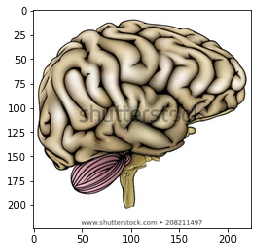

生成文: illustration of a heart isolated on white background .


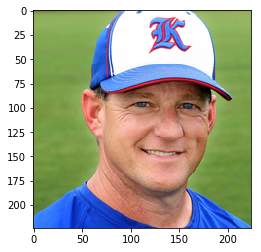

生成文: a man is seen in the wind .


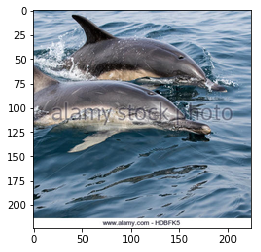

生成文: a close up of biological species


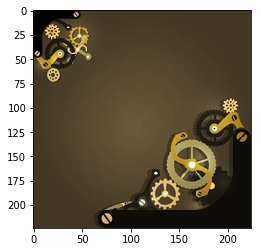

生成文: vector illustration of a banner for holiday .


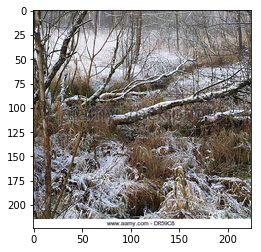

生成文: a view of the trail .


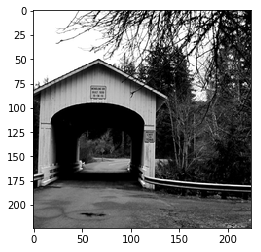

生成文: a small house with a house .


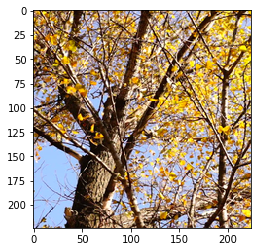

生成文: autumn leaves on a tree


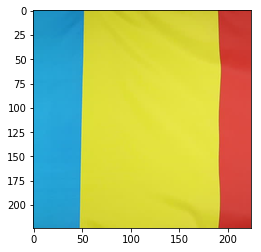

生成文: flag waving in the wind .


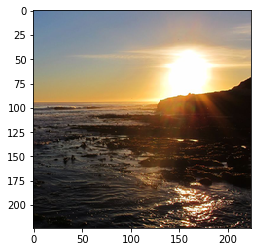

生成文: a city on the beach


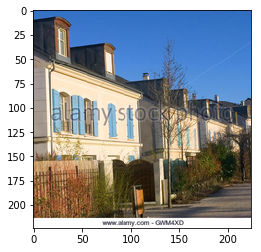

生成文: a view of the building


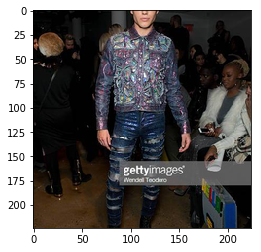

生成文: actor attends the fashion show during fashion week .


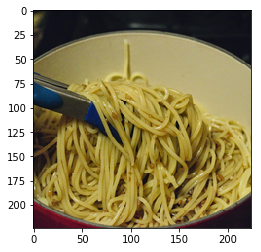

生成文: a close up of a restaurant


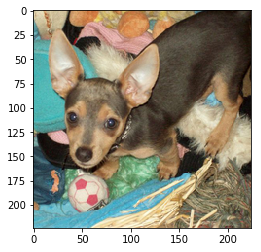

生成文: a view of my dog .


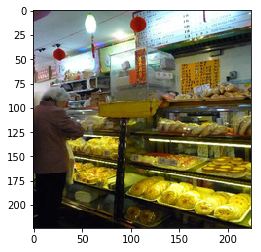

生成文: a home for sale at a restaurant


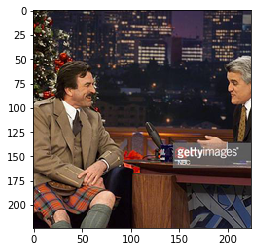

生成文: actor during an interview with comedian


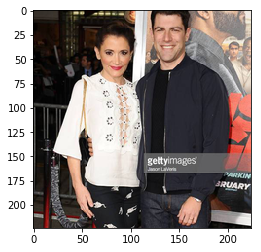

生成文: actor attends the premiere during festival .


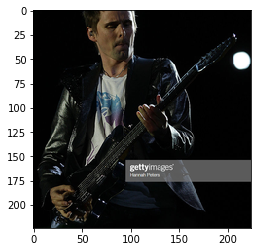

生成文: hard rock artist performs on stage .


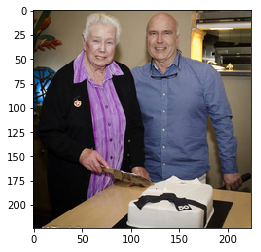

生成文: actors attend the premiere during festival .


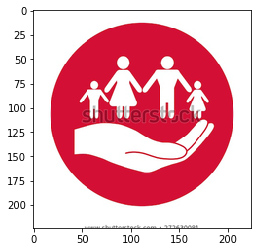

生成文: vector illustration of a banner for holiday .


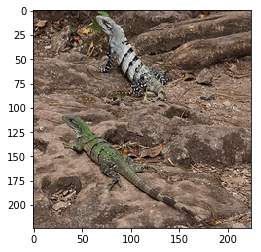

生成文: portrait of a dog on a white background


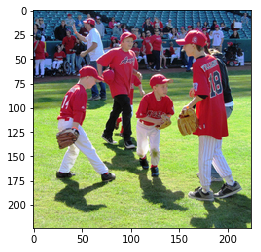

生成文: players celebrate after the game against sports team .


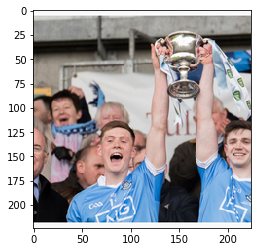

生成文: football player in action during the match .


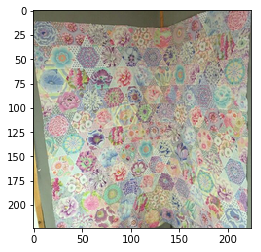

生成文: this is a beautiful pattern .


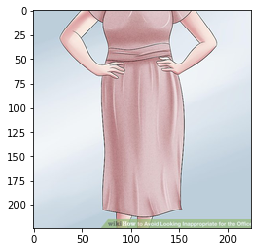

生成文: actor arrives at the premiere .


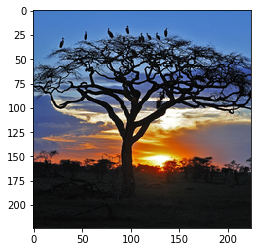

生成文: sunset over a city in the evening .


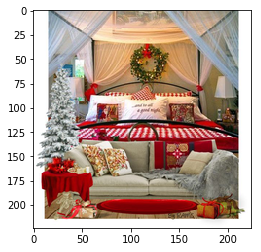

生成文: a close up view of a boat


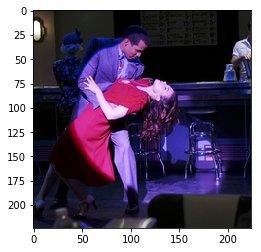

生成文: musical artist performs live on stage .


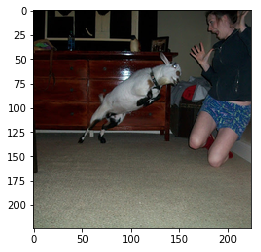

生成文: actor attends the film premiere .


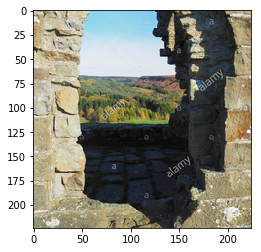

生成文: a city in the old town


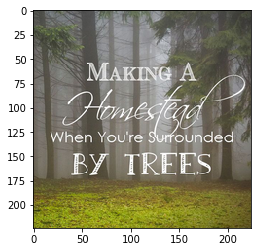

生成文: a close up of a movie


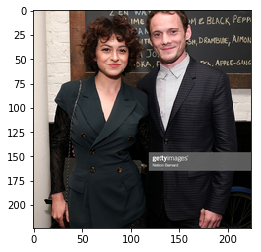

生成文: actors attend the premiere during festival .


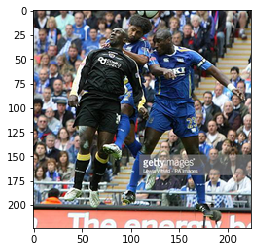

生成文: football player and battle for the ball


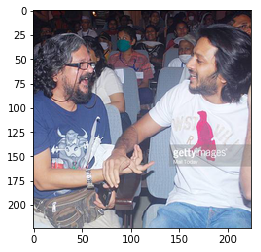

生成文: man with a man with a man


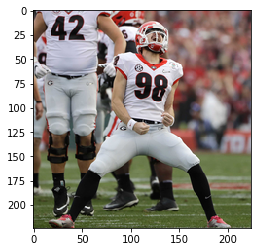

生成文: american football player during the game against sports team .


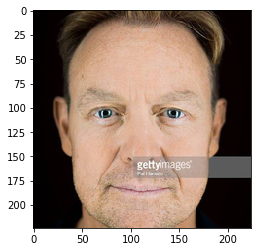

生成文: actor arrives at the premiere


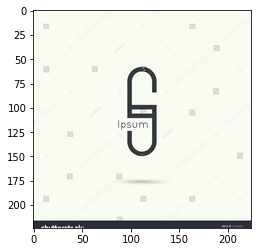

生成文: vector illustration on a white background .


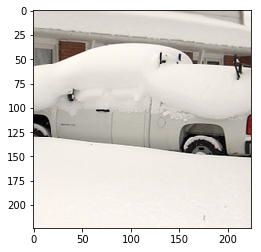

生成文: aircraft model in the mountains


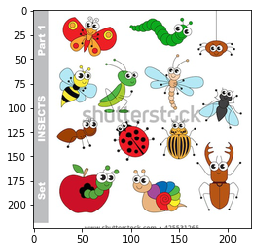

生成文: set of flowers on a white background .


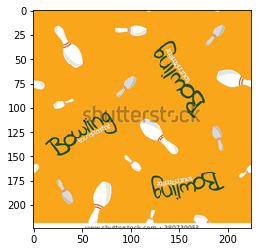

生成文: vector illustration of a banner for holiday .


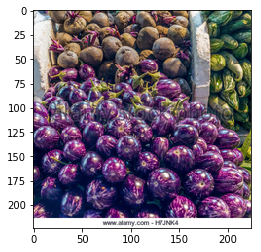

生成文: close up of a plant on a white background


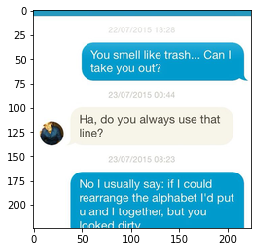

生成文: the logo on the website .


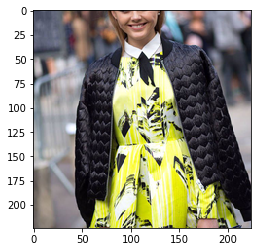

生成文: actor attends the premiere during festival .


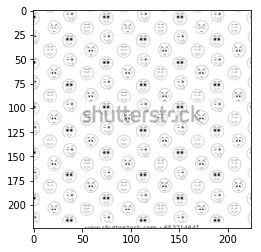

生成文: seamless pattern with a white background


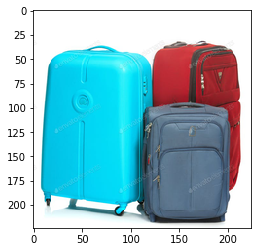

生成文: cute family with a red carpet .


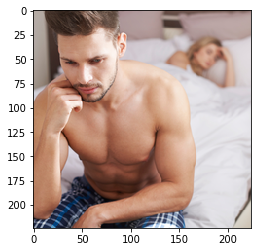

生成文: portrait of a man with a man


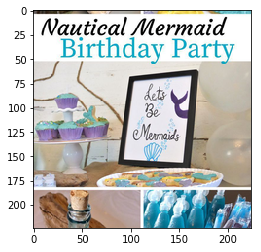

生成文: table with a table and a table .


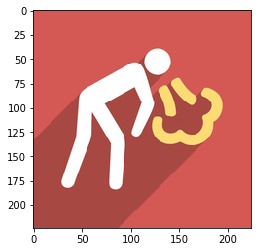

生成文: digital art selected for the #


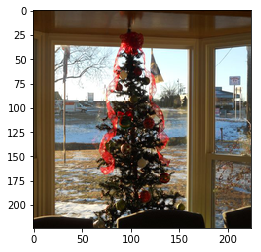

生成文: the view from the living room .


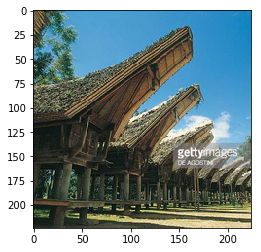

生成文: a view of the interior of the building .


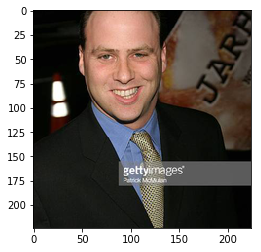

生成文: actor arrives at the premiere


In [0]:
s = slice(0, 1000)
for y_pred, test_pic in zip(output[s], x_test[s]):
    plt.imshow(test_pic / 255.)
    plt.show()
    print('生成文:', ' '.join([detokenizer[i] for i in y_pred]))

In [0]:
# output csv
with open('/root/userspace/submission_xcepemb2048hid512_drop_final.csv', 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerows(output)

In [0]:
! pip3 install scikit-image

    100% |################################| 26.5MB 56kB/s  eta 0:00:01   16% |#####                           | 4.3MB 53.9MB/s eta 0:00:01
    100% |################################| 4.4MB 353kB/s eta 0:00:01
    100% |################################| 3.3MB 493kB/s eta 0:00:01
You are using pip version 8.1.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


(6, 49)


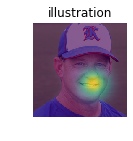

In [0]:
import skimage.transform

fig = plt.figure(figsize=(18, 10))
#print(x_test.shape)
for i, (wordid, att_a_t) in enumerate(zip(y_pred[1:-1], att_a)):
    ax = fig.add_subplot(5, 5, i+1)
    print(np.array(att_a_t).shape)
    att_a_t=att_a_t[1]
    # Plot image
    ax.imshow(x_test[1] / 255.)
    ax.axis('off')
    
    # Plot attention
    att_a_t = skimage.transform.pyramid_expand(att_a_t.reshape(7, 7), upscale=32, sigma=20, multichannel=False)
    ax.imshow(att_a_t, alpha=.65)
    # Plot word
    ax.set_title(detokenizer[wordid])
    break

plt.show()